In [1]:
# add Changepoints
using Changepoints

In [2]:
# define cumulative sum of functions in a given time interval
function zero_cumsum(x::Array{T, 1}) where T
    res = Array{T, 1}(undef, length(x) + 1)

    res[1] = zero(T)
    for i in 1:length(x)
        res[i + 1] = res[i] + x[i]
    end

    return res
end

function zero_cumsum(f::Function, x::Array{T, 1}) where T
    res = Array{T, 1}(undef, length(x) + 1)

    res[1] = zero(T)
    for i in 1:length(x)
        res[i + 1] = res[i] + f(x[i])
    end

    return res
end

zero_cumsum (generic function with 2 methods)

In [3]:
# compute cost of segments using sum of squares
function calc_segment_cost(data::Array{Float64}, σ::Real = 1.0)
    cd = zero_cumsum(data)
    cd_2 = zero_cumsum(x -> x^2, data)
    cost(s::Int64, t::Int64) =
        ( cd_2[t+1] - cd_2[s+1] - abs2(cd[t+1] - cd[s+1]) / (t-s) ) / (σ^2)
    return cost
end

calc_segment_cost (generic function with 2 methods)

In [4]:
using GuidedProposals, DiffusionDefinition, ObservationSchemes
const GP = GuidedProposals
const DD = DiffusionDefinition
const OBS = ObservationSchemes

using StaticArrays, Random, Plots, LinearAlgebra
using Statistics

# seed used for this tutorial
Random.seed!(100)

## data generation ##
@diffusion_process FavettoSamsonModified{T,K} begin
    :dimensions
    process --> 2
    wiener --> 2

    :parameters
    (α, β, λ, μ, σ1, σ2) --> T
    dose --> K

    :additional
    diagdiff --> true
    constdiff --> true
end

DiffusionDefinition.b(t, x, P::FavettoSamsonModified) = @SVector [
    P.α * P.dose(t) - (P.λ +P.β)*x[1] + (P.μ-P.λ)*x[2],
    P.λ*x[1] - P.μ*x[2]
]

DiffusionDefinition.σ(t, x, P::FavettoSamsonModified) = SDiagonal(P.σ1, P.σ2)

A new struct `FavettoSamsonModified{T, K}` has been defined.


In [5]:
function true_aif(t)
    t / (1 + t * t)
end

true_aif (generic function with 1 method)

In [6]:
θ = [116.7, 5.83, 1.25, 2.25, 2.0, 1.0]
P_target = FavettoSamsonModified(θ..., t-> t/(1+t^2))
tt, y1 = 0.0:0.0001:10.0, @SVector [0.0, 0.0]
X = rand(P_target, tt, y1)

data = map(
    x->(x[1], x[2] + randn()),
    collect(zip(X.t, X.x))[1:1000:end]
)[2:end]

data1 = map(
    x->(x[1], x[2][1] + x[2][2] + randn()),
    collect(zip(X.t, X.x))[1:1000:end]
)[2:end]

data2 = map(
    x->(x[1], x[2][1] + randn()),
    collect(zip(X.t, X.x))[1:1000:end]
)[2:end]

sum_of_coordinates = [data1[i][2] for i in 1:100]

100-element Vector{Float64}:
  0.3238862110206477
  1.3041833109046894
  2.063221442987703
  2.6355111544536154
  6.619106049354457
  9.467036451416476
  8.584587055763159
 10.154366004124364
 10.672193141611332
  8.892689392716381
 12.173223067728035
 11.29154330098038
 13.758476904348466
  ⋮
  2.479978419868383
  0.8888083536193401
  1.4888581208323433
  1.594460747777299
  2.621353160735445
  1.6750765434252135
  4.996437194602262
  4.439862803717164
  4.63016652585093
  4.163897155108219
  4.769372406760541
  4.160672558232433

In [7]:
# let's examine the data
plot(X, Val(:vs_time), size=(800, 300))
scatter!(map(x->x[1], data), map(x->x[2][1], data), label="data")

In [8]:
difference_data = [sum_of_coordinates[i]-sum_of_coordinates[i-1] for i in 2:length(sum_of_coordinates)]

99-element Vector{Float64}:
  0.9802970998840417
  0.7590381320830135
  0.5722897114659125
  3.9835948949008415
  2.847930402062019
 -0.8824493956533175
  1.569778948361206
  0.5178271374869681
 -1.7795037488949514
  3.280533675011654
 -0.8816797667476557
  2.466933603368087
  0.6942200477379608
  ⋮
  0.01972641068168768
 -1.5911700662490431
  0.6000497672130032
  0.1056026269449557
  1.026892412958146
 -0.9462766173102315
  3.321360651177048
 -0.556574390885098
  0.19030372213376623
 -0.4662693707427108
  0.6054752516523223
 -0.6086998485281088

In [9]:
function time_delay_estimation(data)
    n = length(data)
    # initialisation
    mean0 = mean(data)
    ssq = [(data[i]-mean(data))^2 for i in 1:length(data)]
    ssq_old = sum(ssq)
    ssq_new = ssq_old
    index = 1
    for i in 1:n
        ssq_new = 0
        before_mean = mean(data[1:i])
        after_mean = mean(data[i+1:n])
        for j in 1:i
            ssq_new += (data[j]-before_mean)^2
        end
        for j in i+1:n
            ssq_new += (data[j]-after_mean)^2
        end
        if ssq_new < ssq_old
            index = i
            ssq_old = ssq_new
        end
    end
    println(index)
end

time_delay_estimation (generic function with 1 method)

In [10]:
time_delay_estimation(difference_data)

5


In [11]:
# binary segmentation method
function BS( segment_cost::Function , n::Int64; pen::Float64 = log(n) )
    tau = Tuple{Int, Int}[] # Segmentations to test
    CP = Array{Int64}(undef,0)

    push!(tau, (0, n))
    push!(CP, 0)

    # keep adding segments until none contain a changepoint

    while length(tau) > 0
        a, b = pop!(tau)
        x = Array{Float64}(undef, 0)
        for j in (a+1):(b - 1)
            push!(x , segment_cost(a,j) + segment_cost(j,b) + pen)
        end
        minval , ind = findmin(x)
        if minval - segment_cost(a,b) < 0
            # significant so add seg to tau
            chpt = ind + a
            push!(CP,chpt)
            if chpt != a + 1;
                push!(tau, (a, chpt))
            end
            if chpt != b - 1
                push!(tau, (chpt,b))
            end
        end
    end

    cost = 0.0

    CP = sort(CP)

    for j in 1:(length(CP)-1)
        cost = cost + segment_cost(CP[j]+1,CP[j+1]) + pen
    end

    cost = cost + segment_cost(CP[end]+1,n)

    return CP, cost
end

BS (generic function with 1 method)

In [12]:
# Run binary segmentation (BS) on data (sum of coordinates), detect all the changepoints
seg_cost = calc_segment_cost(sum_of_coordinates,1.0)
BS_cps, BS_cost = BS(seg_cost,100)
append!(BS_cps, 100)
println(BS_cps)

[0, 4, 5, 10, 26, 42, 44, 48, 63, 85, 94, 100]


In [13]:
@diffusion_process FavettoSamsonAux{K,Q,R} begin
    :dimensions
    process --> 2
    wiener --> 2

    :parameters
    (α, β, λ, μ, σ1, σ2) --> K
    dose --> Q
    :auxiliary_info
    t0 --> Float64
    T --> Float64
    vT --> R

    :additional
    constdiff --> true
    linear --> true
end

DiffusionDefinition.B(t, P::FavettoSamsonAux) = @SMatrix [-(P.λ+ P.β) P.β; P.λ -P.μ]
DiffusionDefinition.β(t, P::FavettoSamsonAux) = @SVector [P.α* P.dose(t), 0.0]
DiffusionDefinition.σ(t, P::FavettoSamsonAux) = SDiagonal(P.σ1, P.σ2)

@load_diffusion FavettoSamsonAux

A new struct `FavettoSamsonAux{K, Q, R}` has been defined.


In [14]:
# define a simple transition kernel
function customkernel(θ, s::Symbol, scale=0.1)
	θ° = deepcopy(θ)
	θ°[s] += 2.0*scale*(rand()-0.5)
	θ°
end

customkernel (generic function with 2 methods)

In [15]:
"""
Adaptive readjustment for the `i`th recording of the preconditioned
Crank–Nicolson scheme's memory parameter.
"""
max_p, min_p = 1e7, 1e-12
target_rate = 0.44
# define a time delay
offset = 1e2

function readjust(p_old, accpt_r, δ, mcmc_iter)
    p = sigmoid(logit(p_old)-(2*(accpt_r > target_rate)-1)* δ)
    p = max.(min.(p,  max_p), min_p)
end

sigmoid(x, a=1.0) = 1.0 / (1.0 + exp(-a*x))
logit(x, a=1.0) = (log(x) - log(1-x))/a

"""
    compute_δ(p, mcmc_iter)
δ decreases roughly proportional to scale/sqrt(iteration)
"""
function compute_δ(mcmc_iter)
    1.0 / sqrt(
        max(1.0, mcmc_iter/100 -offset)
    )
end

compute_δ

In [16]:
function simple_inference(AuxLaw, recording, dt, θ; ρ=0.5, num_steps=10^4, cp_list)
	# initializations
	tts = OBS.setup_time_grids(recording, dt)
	PP = build_guid_prop(AuxLaw, recording, tts)
	PP° = deepcopy(PP)

	y1 = rand(recording.x0_prior) # just returns the starting point
	XX, WW, Wnr = rand(PP, y1)
	XX°, WW° = trajectory(PP)

	ll = loglikhd(PP, XX)
	paths = []
	θθ = Float64[θ[:α],]
    aif_list = Float64[θ[:α],]
    bin_avg = Float64[]
	imp_a_r = 0
	param_a_r = 0

	# MCMC
	for i in 1:num_steps
		# impute a path
		_, ll° = rand!(PP, XX°, WW°, WW, ρ, Val(:ll), y1; Wnr=Wnr)

		if rand() < exp(ll°-ll)
        # 试着改用ρ?
#         if ρ < exp(ll°-ll)
			XX, WW, XX°, WW° = XX°, WW°, XX, WW
			ll = ll°
			imp_a_r += 1
		end

		# update parameter
		θ° = customkernel(θ, :α, 0.1)
		DD.set_parameters!(PP°, θ°)
		recompute_guiding_term!(PP°)
		_, ll° = GP.solve_and_ll!(XX°, WW, PP°, y1)

		if rand() < exp(ll°-ll) # uniform updates have no contribution to ll
#         if ρ < exp(ll°-ll)
			XX, PP, θ, XX°, PP°, θ° = XX°, PP°, θ°, XX, PP, θ
			ll = ll°
			param_a_r += 1
		end
		append!(θθ, [θ[:α]])
        append!(aif_list, [θ[:α]])
        
        # 分段对每个time bin中的data进行estimate α
        # piecewise constant by posterior mean
        if i in 100  .* cp_list
            append!(bin_avg, mean(aif_list))
            aif_list = Float64[]
        end


		# progress message
		if i % 100 == 0
			println(
				"$i. ll=$ll, α=$(θ[:α]), imp accpt rate: $(imp_a_r/100), ",
				"updt accpt rate: $(param_a_r/100)"
			)
            accpt_r = imp_a_r / 100
            δ = compute_δ(i)
            ρ = readjust(ρ, accpt_r, δ, i)
			imp_a_r = param_a_r = 0
		end

		# save intermediate path for plotting
		i % 400 == 0 && append!(paths, [deepcopy(XX)])
	end
	paths, θθ, bin_avg
end

simple_inference (generic function with 1 method)

In [17]:
# let's declare which parameters are not changing
DD.const_parameter_names(::Type{<:FavettoSamsonModified}) = (:β :λ, :μ, :σ1, :σ2) 
DD.const_parameter_names(::Type{<:FavettoSamsonAux}) = (:β, :λ, :μ, :σ1, :σ2, :t0, :T, :vT, :xT)

In [18]:
AIF_list = Float64[0,]
avg_list = Float64[]
true_aif_list = Float64[0,]
true_value_list = Float64[0,]
for k in 1:length(BS_cps)-1
    time_range = BS_cps[k+1]-BS_cps[k]
    # left endpoint should be open!
    idx1 = BS_cps[k]
    idx2 = BS_cps[k+1]
    if k == 1
        subdata = data1[1:idx2]
    end
    if k != 1
        subdata = data1[idx1:idx2]
        deleteat!(subdata,1)
    end
    recording = (
        P = FavettoSamsonModified([#==# 0.0 #==#, 5.83, 1.25, 2.25, 2.0, 1.0]..., t->116.7), # diffusion law
        obs = load_data(
            ObsScheme(
                LinearGsnObs(0.0, (@SVector [0.0]);L=(@SMatrix [1.0 1.0]),Σ=(@SMatrix [1]))
            ),
            subdata
        ),
        t0 = 0.0,
        x0_prior = KnownStartingPt(y1),
    )
#     DD.const_parameter_names(::Type{<:FavettoSamsonModified}) = (:β :λ, :μ, :σ1, :σ2) 
#     DD.const_parameter_names(::Type{<:FavettoSamsonAux}) = (:β, :λ, :μ, :σ1, :σ2, :t0, :T, :vT, :xT)
    paths, θθ, bin_avg = simple_inference(
        FavettoSamsonAux, recording, 0.1, Dict(:α => 0.0); ρ= 0.5, num_steps= 100 * time_range, cp_list = BS_cps
    )
    append!(AIF_list,θθ)
    append!(avg_list, bin_avg)
    true_value = Float64[]
    for t in 100*BS_cps[k]:1:100*BS_cps[k+1]
        append!(true_value,true_aif(t/1000))
        append!(true_value_list,true_aif(t/1000))
    end
    for num in 100*BS_cps[k]:1:100*BS_cps[k+1]
        append!(true_aif_list, mean(true_value))
    end
end

100. ll=-4.878042246564062, α=0.10479390050496089, imp accpt rate: 0.89, updt accpt rate: 0.48
200. ll=-4.696941641692866, α=0.11884786162666577, imp accpt rate: 0.89, updt accpt rate: 0.55
300. ll=-4.999157226408281, α=0.1610606658374384, imp accpt rate: 0.94, updt accpt rate: 0.65
400. ll=-6.961702812627255, α=0.00664368248664634, imp accpt rate: 0.94, updt accpt rate: 0.62
100. ll=-1.5963463795664437, α=0.23567207829405512, imp accpt rate: 0.8, updt accpt rate: 0.76
100. ll=-1.3124642814793086, α=0.38413863215965177, imp accpt rate: 0.28, updt accpt rate: 0.47
200. ll=-3.3558351378637883, α=0.39332644398485395, imp accpt rate: 0.37, updt accpt rate: 0.46
300. ll=-3.8391345753558053, α=0.38386339113481416, imp accpt rate: 0.35, updt accpt rate: 0.56
400. ll=-2.36105405394526, α=0.4025736279029732, imp accpt rate: 0.71, updt accpt rate: 0.52
500. ll=-4.284859009430455, α=0.42595550395705467, imp accpt rate: 0.52, updt accpt rate: 0.44
100. ll=-19.54754622792808, α=0.4202376905641574, 

500. ll=-13.449743745430055, α=0.011187530322181179, imp accpt rate: 0.66, updt accpt rate: 0.32
600. ll=-12.378964534837152, α=0.04200659024043412, imp accpt rate: 0.84, updt accpt rate: 0.39
700. ll=-13.457946347181885, α=0.031614366726928404, imp accpt rate: 0.62, updt accpt rate: 0.44
800. ll=-11.518158052521658, α=0.05350455968519832, imp accpt rate: 0.68, updt accpt rate: 0.39
900. ll=-13.399076149046332, α=0.07891193511311838, imp accpt rate: 0.37, updt accpt rate: 0.34
100. ll=-7.024215272061927, α=0.13628866964718028, imp accpt rate: 0.65, updt accpt rate: 0.42
200. ll=-2.93099477077675, α=0.18080423609419716, imp accpt rate: 0.42, updt accpt rate: 0.46
300. ll=-6.677315495058031, α=0.14342736663505687, imp accpt rate: 0.63, updt accpt rate: 0.31
400. ll=-8.527595484532931, α=0.1598672708374139, imp accpt rate: 0.56, updt accpt rate: 0.36
500. ll=-7.9601465581199955, α=0.11394739840570614, imp accpt rate: 0.4, updt accpt rate: 0.45
600. ll=-4.66240987409491, α=0.20933133677381

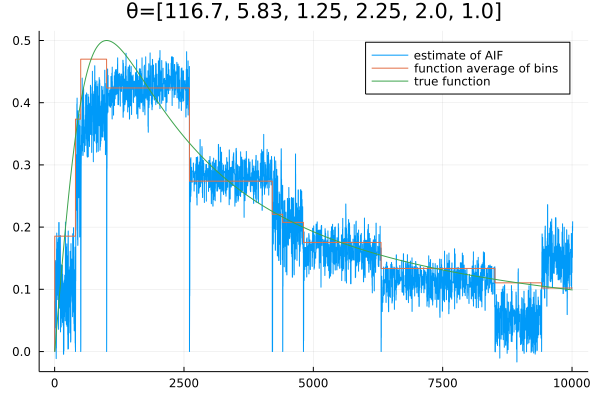

In [19]:
p1 = plot(AIF_list, title = "θ=[116.7, 5.83, 1.25, 2.25, 2.0, 1.0]",label="estimate of AIF")
plot!(true_aif_list, label="function average of bins")
plot!(true_value_list, label="true function")
display(p1)
savefig("AIF_estimate")